In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
from scipy.integrate import odeint
from scipy.stats import norm
import matplotlib.pyplot as plt
import dask.bag as db

In [2]:
def make_lognormal_params_95_ci(lb, ub):
    mean = (ub*lb)**(1/2)
    std = (ub/lb)**(1/4)
    return mean, std

In [3]:
def run_SEIR_BAYES_model(
        N: 'population size',
        E0: 'init. exposed population',
        I0: 'init. infected population',
        R0: 'init. removed population',
        R0__params: 'repr. rate mean and std',
        gamma_inv_params: 'removal rate mean and std',
        alpha_inv_params: 'incubation rate mean and std',
        t_max: 'numer of days to run',
        runs: 'number of runs'
    ):

    S0 = N - (I0 + R0 + E0)
    t_space = np.arange(0, t_max)

    size = (t_max, runs)

    S = np.zeros(size)
    E = np.zeros(size)
    I = np.zeros(size)
    R = np.zeros(size)
    
    S[0, ], E[0, ], I[0, ], R[0, ] = S0, E0, I0, R0

    R0_ = npr.lognormal(*map(np.log, R0__params), runs)
    gamma = 1/npr.lognormal(*map(np.log, gamma_inv_params), runs)
    alpha = 1/npr.lognormal(*map(np.log, alpha_inv_params), runs)
    beta = R0_*gamma
   
    for t in t_space[1:]:
        SE = npr.binomial(S[t-1, ].astype('int'), 1 - np.exp(-beta*I[t-1, ]/N))
        EI = npr.binomial(E[t-1, ].astype('int'), 1 - np.exp(-alpha))
        IR = npr.binomial(I[t-1, ].astype('int'), 1 - np.exp(-gamma))

        dS =  0 - SE
        dE = SE - EI
        dI = EI - IR
        dR = IR - 0

        S[t, ] = S[t-1, ] + dS
        E[t, ] = E[t-1, ] + dE
        I[t, ] = I[t-1, ] + dI
        R[t, ] = R[t-1, ] + dR
    
    return S, E, I, R, t_space

In [4]:
def seir_bayes_plot(N, E0, I0, R0,
                    R0__params,
                    gamma_inv_params,
                    alpha_inv_params,
                    t_max, runs, S, E, I, R, t_space):
    S0 = N - (I0 + R0 + E0)
    # plot
    algorithm_text = (
        f"for {runs} runs, do:\n"
        f"\t$S_0={S0}$\n\t$E_0={E0}$\n\t$I_0={I0}$\n\t$R_0={R0}$\n"
         "\t$\\gamma \\sim LogNormal(\mu={:.04}, \\sigma={:.04})$\n"
         "\t$\\alpha \\sim LogNormal(\mu={:.04}, \\sigma={:.04})$\n"
         "\t$R0 \\sim LogNormal(\mu={:.04}, \\sigma={:.04})$\n"
        f"\t$\\beta = \\gamma R0$\n"
        f"\tSolve SEIR$(\\alpha, \\gamma, \\beta)$"
    ).format(*gamma_inv_params, *alpha_inv_params, *R0__params)

    title = '(RESULTADO PRELIMINAR) Pessoas afetadas pelo COVID-19, segundo o modelo SEIR-Bayes'
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(16,9))
    plt.plot(t_space, E.mean(axis=1), '--', t_space, I.mean(axis=1), '--', marker='o')
    plt.title(title, fontsize=20)
    plt.legend(['Expostas ($\mu \pm \sigma$)',
                'Infectadas ($\mu \pm \sigma$)'],
               fontsize=20, loc='lower right')
    plt.xlabel('t (Dias a partir de 17/Março/2020)', fontsize=20)
    plt.ylabel('Pessoas', fontsize=20)
    plt.fill_between(t_space,
                     I.mean(axis=1) + I.std(axis=1), 
                     (I.mean(axis=1) - I.std(axis=1)).clip(I0),
                     color='b', alpha=0.2)
    plt.fill_between(t_space, 
                     E.mean(axis=1) + E.std(axis=1), 
                     (E.mean(axis=1) - E.std(axis=1)).clip(I0),
                     color='r', alpha=0.2)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, algorithm_text,
            transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)
    plt.yscale('log')
    return fig

In [5]:
def seir_bayes_interactive_plot(N, E0, I0, R0,
                                t_max, runs, S, E, I, R, t_space,
                                scale='log', show_uncertainty=True):

    from .visualization import prep_tidy_data_to_plot, make_combined_chart
    source = prep_tidy_data_to_plot(E, I, t_space)
    chart = make_combined_chart(source, 
                                scale=scale, 
                                show_uncertainty=show_uncertainty)
    return chart

In [6]:
def seir_bayes_df_pop(
        R0__params: 'repr. rate upper and lower limits' = (1.96, 2.55),
        gamma_inv_params: 'removal rate upper and lower limits' = (10, 16),
        alpha_inv_params: 'incubation rate upper and lower limits' = (4.1, 7),
        t_max: 'numer of days to run' = 30,
        runs: 'number of runs' = 1000,
        date: 'load SEIR(0) for this date' = 'latest' 
    ):

    def estimate_removed_and_exposed(df):
        return (df
                .sort_values('date')
                .assign(removed_est=lambda df: df.cases.shift(1).fillna(0) + df.new_cases - df.cases)
                .assign(exposed_est=lambda df: (df.cases
                                                  .shift(-int(alpha_inv_params[1]))
                                                  .fillna(method='ffill')
                                                  .fillna(0))))

    population = pd.read_csv('data/csv/population/by_city/by_city.csv', index_col=['uf', 'city'])
    covid19 = pd.read_csv('data/csv/covid_19/by_city/by_city.csv', parse_dates=['date'])


    date = covid19['date'].max() if date == 'latest' else date

    # if this fails, something is wrong with the data
    assert population.index.is_unique
    assert covid19.index.is_unique

    SEIR_0 = (
        covid19
        .groupby(['uf', 'city'], group_keys=False)
        .apply(estimate_removed_and_exposed)
        [lambda df: df['date'] == date]
        .set_index(['uf', 'city'])
        .join(population, how='left')
        .reset_index()
        [['uf', 'city', 'estimated_population', 'exposed_est', 'cases', 'removed_est']]
        .query("cases >= 5")
        .to_dict(orient='records')
    )

    # In:  SEIR_0[:2]
    # Out: [{'uf': 'AC',
    #        'city': 'Rio Branco',
    #        'estimated_population': 407319.0,
    #        'exposed_est': 0.0,
    #        'cases': 4,
    #        'removed_est': 0.0},
    #       {'uf': 'AL',
    #        'city': 'Maceió',
    #        'estimated_population': 1018948.0,
    #        'exposed_est': 3.0,
    #        'cases': 4,
    #        'removed_est': 0.0}]

    def run_model(params):
        N = params['estimated_population']
        E0 = params['exposed_est']
        I0 = params['cases']
        R0 = params['removed_est']
        model_input = (N, E0, I0, R0, R0__params,
                       gamma_inv_params, alpha_inv_params,
                       t_max, runs)
        try:
            return {**params, 'results': run_SEIR_BAYES_model(*model_input), 'error': False}
        except:
            return {**params, 'results': model_input, 'error': True}

    return (db.from_sequence(SEIR_0)
              .map(run_model)
              .compute(scheduler='processes'))

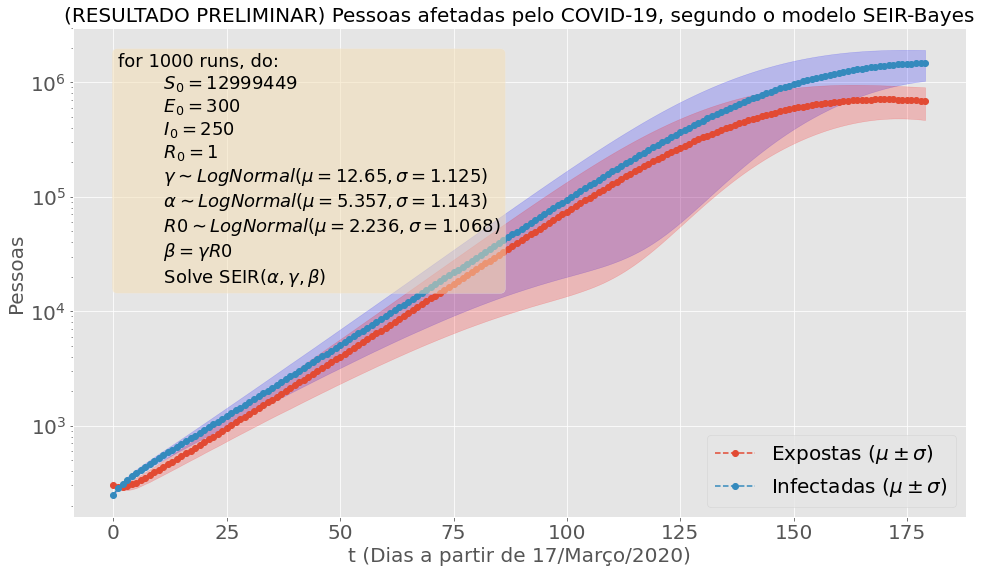

In [7]:
if __name__ == '__main__':
    N = 13_000_000
    E0, I0, R0 = 300, 250, 1
    R0__params = make_lognormal_params_95_ci(1.96, 2.55)
    gamma_inv_params = make_lognormal_params_95_ci(10, 16)
    alpha_inv_params = make_lognormal_params_95_ci(4.1, 7)
    t_max = 30*6
    runs = 1_000
    S, E, I, R, t_space = run_SEIR_BAYES_model(
                                      N, E0, I0, R0,
                                      R0__params,
                                      gamma_inv_params,
                                      alpha_inv_params,
                                      t_max, runs)

    fig = seir_bayes_plot(N, E0, I0, R0,
                          R0__params,
                          gamma_inv_params,
                          alpha_inv_params,
                          t_max, runs, S, E, I, R, t_space)
    plt.show()

In [ ]:
seir_bayes_df_pop()

In [ ]:
run_SEIR_BAYES_model()

In [15]:
import pandas as pd

In [43]:
dados_covid = pd.DataFrame({'infectados': I.mean(axis=1),
                            'hospitalizados': I.mean(axis=1) * 0.3594})

In [44]:
dados_covid['hospitalizados'] = dados_covid['hospitalizados'].astype(int)

In [45]:
dados_covid.to_csv('dados_covid.csv')

In [22]:
I.mean(axis=1)

array([2.50000000e+02, 2.82788000e+02, 3.11830000e+02, 3.38364000e+02,
       3.63370000e+02, 3.88011000e+02, 4.12768000e+02, 4.38160000e+02,
       4.65357000e+02, 4.92873000e+02, 5.22586000e+02, 5.52757000e+02,
       5.84234000e+02, 6.17805000e+02, 6.53681000e+02, 6.91303000e+02,
       7.31038000e+02, 7.73518000e+02, 8.18487000e+02, 8.65811000e+02,
       9.15447000e+02, 9.68907000e+02, 1.02487400e+03, 1.08483900e+03,
       1.14718800e+03, 1.21454000e+03, 1.28578200e+03, 1.35985500e+03,
       1.43905000e+03, 1.52322800e+03, 1.61181800e+03, 1.70620200e+03,
       1.80597300e+03, 1.91141600e+03, 2.02318100e+03, 2.14225500e+03,
       2.26806000e+03, 2.40078400e+03, 2.54247400e+03, 2.69375700e+03,
       2.85004000e+03, 3.01723800e+03, 3.19450500e+03, 3.38336500e+03,
       3.58227200e+03, 3.79447600e+03, 4.02092000e+03, 4.25890800e+03,
       4.51053700e+03, 4.77863200e+03, 5.06425900e+03, 5.36632800e+03,
       5.68635400e+03, 6.02498000e+03, 6.38433900e+03, 6.76667000e+03,
      